In [2]:
# Setting .env
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("HF_TOKEN")

### What we're going to build

We're going to be bulding a `food`/`not_food` **text classification model**. 

Given a piece of a text (such as an image caption), our model will be able to predict if it's about food or not.

More specifically, we're going to follow the following steps:

1. **[Data](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions): Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **[Model](https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased): Finding, training and evaluating a model** - Finding a text classification model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **[Demo](https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo): Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo) you can share with others:

### Import Necessary Libraries

In [3]:
# install dependencies
try:
    import datasets, evaluate, accelerate
    import gradio as gr
except ModuleNotFoundError:
    %pip install -U datasets, evaluate, accelerate, gradio
    import datasets, evaluate, accelerate
    import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"Torch version: {torch.__version__}")


2024-11-17 10:59:25.507609: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 10:59:25.746639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 10:59:25.746680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 10:59:25.786496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 10:59:25.868968: I tensorflow/core/platform/cpu_feature_guar

Transformers version: 4.44.2
Datasets version: 3.0.0
Torch version: 2.4.1+cu121


## Loading a Dataset

In [4]:
# Load the dataset from hugging face hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# inspect the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [5]:
# what features are there
dataset.column_names

{'train': ['text', 'label']}

In [6]:
# Access the training split
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [7]:
dataset['train'][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

### Inspect random examples from the dataset

In [8]:
import random

random_indexes = random.sample(range(len(dataset['train'])), 5)
random_samples  = dataset['train'][random_indexes]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples['text'], random_samples['label']):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Tangy fish curry bowl, featuring delicate fish pieces in a zesty sauce made with tamarind and curry leaves, ideal for a light meal. | Label: food
Text: Drone resting on a desk | Label: not_food
Text: Beets in a bowl, sprinkled with goat cheese and served with a side of arugula for a sophisticated, flavorful dish. | Label: food
Text: Wooden dresser with a mirror reflecting the room | Label: not_food
Text: A pair of slices from a barbecue chicken pizza | Label: food


In [9]:
# Get unique label values
dataset['train'].unique('label')

['food', 'not_food']

In [10]:
# Check number of each label
from collections import Counter

Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [11]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df

,text,label
0,"Creamy cauliflower curry with garlic naan, fea...",food
1,Set of books stacked on a desk,not_food
2,"Watching TV together, a family has their dog s...",not_food
3,Wooden dresser with a mirror reflecting the room,not_food
4,Lawn mower stored in a shed,not_food
...,...,...
245,Standing floor lamp providing light next to an...,not_food
246,Luxurious coconut shrimp curry on a generous p...,food
247,Barbecue grill waiting on a patio,not_food
248,"Family gathered around a dining table, laughin...",not_food


In [12]:
# Get the value counts of the label column
food_not_food_df['label'].value_counts()

label
food        125
not_food    125
Name: count, dtype: int64

## Preparing data for text classification

### Creating a mapping from labels to numbers

In [13]:
# Create mapping from id2label and label2id
id2label = {'0': 'not_food', '1' : 'food'}
label2id = {'not_food' : '0', 'food' : '1'}

print(id2label)
print(label2id)

{'0': 'not_food', '1': 'food'}
{'not_food': '0', 'food': '1'}


In [14]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique('label')[::-1])}
label2id = {label: idx for idx, label in id2label.items()}

print(f"ID to Label mapping: {id2label}")
print(f"Label to ID mapping: {label2id}")

ID to Label mapping: {0: 'not_food', 1: 'food'}
Label to ID mapping: {'not_food': 0, 'food': 1}


In [15]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
    example['label'] = label2id[example['label']]

    return example

example_sample = {"text": "I love eating chicken.", "label": "food"}

# Test the function 
map_labels_to_number(example_sample)

{'text': 'I love eating chicken.', 'label': 1}

In [16]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [17]:
# Shuffle the dataset and view the first 5 samples (will return different results each time) 
dataset.shuffle()[:5]

{'text': ['Nigiri sushi topped with fresh salmon and tuna slices on vinegared rice.',
  'Spicy vindaloo curry with tender pork pieces, featuring a fiery sauce made with vinegar and chili peppers, perfect for bold flavor lovers.',
  'Vegan sushi roll with ingredients like tofu or grilled vegetables.',
  'Beets in a bowl, sprinkled with goat cheese and served with a side of arugula for a sophisticated, flavorful dish.',
  'Carrots on a plate, served with a side of creamy hummus and a sprinkle of paprika.'],
 'label': [1, 1, 1, 1, 1]}

### Split the dataset into training and test sets

In [18]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [19]:
random_idx_train = random.randint(0, len(dataset['train']))
random_sample_train = dataset['train'][random_idx_train]

random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Set of potholders stored in a drawer
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: A bowl of sliced kiwi with a sprinkle of sugar and a side of yogurt
Label: 1 (food)


### Tokenizing text data

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast = True)

tokenizer

/home/spadmin/miniconda3/envs/tf217/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [21]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [22]:
tokenizer("Machine learning")

{'input_ids': [101, 3698, 4083, 102], 'attention_mask': [1, 1, 1, 1]}

In [23]:
# Get the length of the vocabulary 
length_of_vocab = len(tokenizer.vocab)
print(f"Length of vocabulary is {length_of_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_seq = tokenizer.model_max_length
print(f"Length of max tokenizer input sequence: {max_tokenizer_input_seq}")

Length of vocabulary is 30522
Length of max tokenizer input sequence: 512


In [24]:
tokenizer.vocab['chicken']

7975

In [25]:
# Gets error because this word is not in the vocab
# tokenizer.vocab['shivaji']

when calling the tokenizer on the word, it will automatically split the word into word pieces or subwords.

In [26]:
# We can check what word pieces got broken into with tokenizer.convert_ids_to_tokens(input_ids).
tokenizer.convert_ids_to_tokens(tokenizer('shivaji').input_ids)

['[CLS]', 'shiva', '##ji', '[SEP]']

In [27]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🏏").input_ids)

['[CLS]', '[UNK]', '[SEP]']

Since the tokenizer.vocab is a Python dictionary, we can get a sample of the vocabulary using tokenizer.vocab.items().

In [28]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [29]:
import random
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('concentration', 6693),
 ('sherry', 22268),
 ('[unused908]', 913),
 ('waterways', 21938),
 ('##ets', 8454)]

### Making a preprocessing function to tokenize text

In [30]:
def tokenize_text(examples):
    return tokenizer(examples['text'],
                     padding=True,
                     truncation=True)

In [31]:
example_sample_2 = {'text':"I love chicken", "label":1}

tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 7975, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [32]:
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True,
                                batch_size=1000)

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [33]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



## Setting up an evaluation metric

In [34]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load('accuracy')

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
    predictions, labels = predictions_and_labels

    if len(predictions.shape)>=2:
        predictions = np.argmax(predictions, axis=1)

    return accuracy_metric.compute(predictions=predictions, references=labels)

In [35]:
# Create example list of predictions and labels
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


## Setting up a model for training

In [36]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [37]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels = 2,
    id2label = id2label,
    
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Try and make a prediction with the loaded model (this will error)
# model(**tokenized_dataset['train'][0])

In [39]:
# Inspect the model
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Counting the parameters of our model

In [40]:
def count_params(model):
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

### Create a directory for saving models

In [41]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_classifier-ditsilbert-base-uncased"

# create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased')

### Setting up training arguments with TrainingArguments

In [42]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size= 32,
    per_device_eval_batch_size= 32,
    num_train_epochs=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=3,
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    logging_strategy='epoch',
    report_to='none',
    # push_to_hub=True,
    # hub_token="Token_here",
    hub_private_repo=False
)

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased


In [44]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_s

### Setting up an instance of Trainer

In [45]:
from transformers import Trainer

# setup trainer
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics=compute_accuracy
)

### Training our text classification model

In [46]:
# Train a text classification model
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.417400,0.083413,1.000000
2,0.046400,0.007084,1.000000
3,0.005000,0.002124,1.000000
4,0.001900,0.001155,1.000000
5,0.001100,0.000792,1.000000
6,0.000800,0.000629,1.000000
7,0.000700,0.000546,1.000000
8,0.000600,0.000502,1.000000
9,0.000500,0.000480,1.000000
10,0.000500,0.000473,1.000000


In [47]:
# Inspect training metrics
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 13.761
train_samples_per_second: 145.338
train_steps_per_second: 5.087
total_flos: 18110777160000.0
train_loss: 0.04748272506320583
epoch: 10.0


In [48]:
### Save the model for later use

print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_classifier-ditsilbert-base-uncased


### Inspecting the model training metrics

In [49]:
trainer.state.log_history

[{'loss': 0.4174,
  'grad_norm': 2.438926935195923,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.08341345936059952,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0359,
  'eval_samples_per_second': 1391.063,
  'eval_steps_per_second': 55.643,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0464,
  'grad_norm': 0.1459880918264389,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.007084461860358715,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0286,
  'eval_samples_per_second': 1750.135,
  'eval_steps_per_second': 70.005,
  'epoch': 2.0,
  'step': 14},
 {'loss': 0.005,
  'grad_norm': 0.04345442354679108,
  'learning_rate': 7e-05,
  'epoch': 3.0,
  'step': 21},
 {'eval_loss': 0.0021244550589472055,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0275,
  'eval_samples_per_second': 1816.329,
  'eval_steps_per_second': 72.653,
  'epoch': 3.0,
  'step': 21},
 {'loss': 0.0019,
  'grad_norm': 0.028091881424188614,
  'learning_rate': 6e-05,
  'epoch': 4.0,


In [50]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.4174,
  'grad_norm': 2.438926935195923,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.08341345936059952,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0359,
  'eval_samples_per_second': 1391.063,
  'eval_steps_per_second': 55.643,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0464,
  'grad_norm': 0.1459880918264389,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.007084461860358715,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0286,
  'eval_samples_per_second': 1750.135,
  'eval_steps_per_second': 70.005,
  'epoch': 2.0,
  'step': 14}]

In [53]:
import pprint

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # check to see if "eval"  is in the keys of the item
    if any('eval' in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 2.438926935195923,
  'learning_rate': 9e-05,
  'loss': 0.4174,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.1459880918264389,
  'learning_rate': 8e-05,
  'loss': 0.0464,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.08341345936059952,
  'eval_runtime': 0.0359,
  'eval_samples_per_second': 1391.063,
  'eval_steps_per_second': 55.643,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.007084461860358715,
  'eval_runtime': 0.0286,
  'eval_samples_per_second': 1750.135,
  'eval_steps_per_second': 70.005,
  'step': 14}]


In [56]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.4174,2.438927,0.00009,1.0,7
1,0.0464,0.145988,0.00008,2.0,14
2,0.0050,0.043454,0.00007,3.0,21
3,0.0019,0.028092,0.00006,4.0,28
4,0.0011,0.014909,0.00005,5.0,35


In [57]:
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.083413,1.0,0.0359,1391.063,55.643,1.0,7
1,0.007084,1.0,0.0286,1750.135,70.005,2.0,14
2,0.002124,1.0,0.0275,1816.329,72.653,3.0,21
3,0.001155,1.0,0.0263,1903.353,76.134,4.0,28
4,0.000792,1.0,0.0290,1725.000,69.000,5.0,35


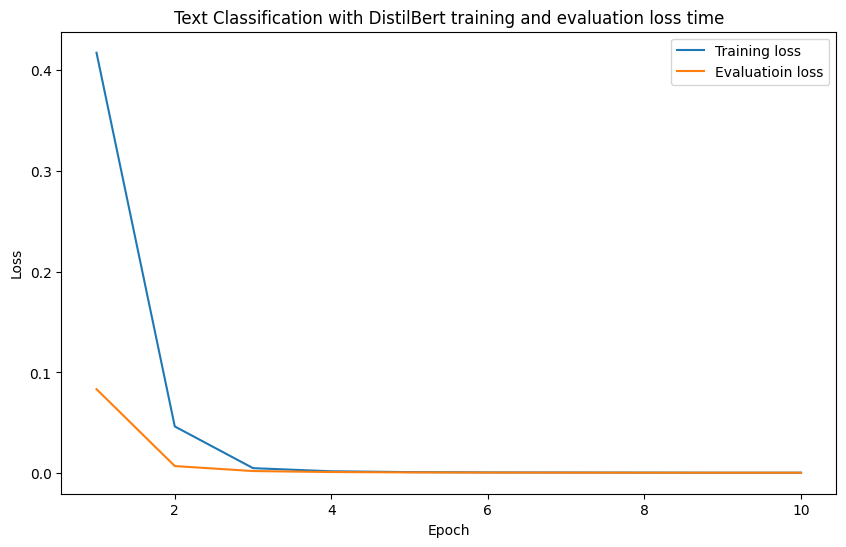

In [58]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(trainer_history_training_df['epoch'], trainer_history_training_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label='Evaluatioin loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text Classification with DistilBert training and evaluation loss time")
plt.legend()
plt.show()

### Pushing our model to the Hugging face

In [60]:
# model_upload_url = trainer.push_to_hub(
#     commit_message="Uploading Food or Not food text classifier Model"
# )

# print(f"[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}")